# Using BERT to do post-OCR correction

This package doesn't seem to be accessible from R.
Following this tutorial, we can use BERT to correct OCR text errors: https://medium.com/states-title/using-nlp-bert-to-improve-ocr-accuracy-385c98ae174c
Below is an partial image cropped from an actual Hansard script from the UK in the 1950. https://commons.wikimedia.org/wiki/File:UKrecognizesIsraelJordan.pdf
The words "intention" and "Kington" are partially scribbled to make them unrecognizable by the OCR package.

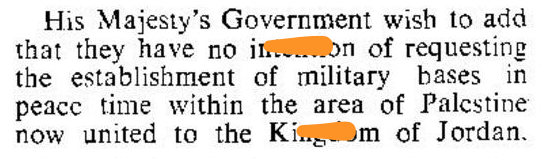

In [65]:
from IPython.display import Image 
Image("./image1.png")

### 1. Import all the required libraries:

* PIL is for image file loading and manipulation
* pytesseract is for OCR proccessing
* torch and pytorch_pretrained_bert are for importing pre-trained BERT model
* re is for regular expression operations
* nltk is for NLP related tasks
* enchant.checker is for spellcheck
* difflib is for comparing sequences

In [66]:
from PIL import Image
from pytesseract import image_to_string
import torch
from pytorch_pretrained_bert import BertTokenizer, BertForMaskedLM
import re
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
from enchant.checker import SpellChecker
from difflib import SequenceMatcher

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kelichiu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/kelichiu/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


### 2. Load the PDF and extract the text through OCR proccess

In [67]:
# Load the Hansard image and 
filename = "./image1.png"
text = image_to_string(Image.open(filename))
text_original = str(text)
print (text)

His Majesty’s Government wish to add
that they have no im@@@l@fon of requesting
the establishment of military bases in
peace time within the area of Palestine
now united to the Kis@@®m of Jordan.



### 3. Clean the text obtained from OCR

In [68]:
# cleanup text
rep = { '\n': ' ', '\\': ' ', '\"': '"', '-': ' ', '"': ' " ', 
        '"': ' " ', '"': ' " ', ',':' , ', '.':' . ', '!':' ! ', 
        '?':' ? ', "n't": " not" , "'ll": " will", '*':' * ', 
        '(': ' ( ', ')': ' ) ', "s'": "s '"}
rep = dict((re.escape(k), v) for k, v in rep.items()) 
pattern = re.compile("|".join(rep.keys()))
text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)

### 4. Use nltk’s “parts of speech” tagging to prevent rare names being flagged as misspellings
SpellChecker flags uncommon names as misspelled words. As a workaround, nltk’s “parts of speech” tagging is used to exclude person names.

In [69]:
def get_personslist(text):
    personslist=[]
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if isinstance(chunk, nltk.tree.Tree) and chunk.label() == 'PERSON':
                personslist.insert(0, (chunk.leaves()[0][0]))
    return list(set(personslist))
personslist = get_personslist(text)
ignorewords = personslist + ["!", ",", ".", "\"", "?", '(', ')', '*', '']
# using enchant.checker.SpellChecker, identify incorrect words
d = SpellChecker("en_US")
words = text.split()
words

['His',
 'Majesty’s',
 'Government',
 'wish',
 'to',
 'add',
 'that',
 'they',
 'have',
 'no',
 'im@@@l@fon',
 'of',
 'requesting',
 'the',
 'establishment',
 'of',
 'military',
 'bases',
 'in',
 'peace',
 'time',
 'within',
 'the',
 'area',
 'of',
 'Palestine',
 'now',
 'united',
 'to',
 'the',
 'Kis@@®m',
 'of',
 'Jordan',
 '.']

### 5. Get the list of text errors
A list of suggested replacements is also retrievable. However, they are given by the SpellChecker, not BERT.

In [70]:
incorrectwords = [w for w in words if not d.check(w) and w not in ignorewords]
# using enchant.checker.SpellChecker, get suggested replacements
suggestedwords = [d.suggest(w) for w in incorrectwords]
# replace incorrect words with [MASK]
incorrectwords

['im@@@l@fon', 'Kis@@®m']

### 6. Turn incorrect words into token [MASK]

In [71]:
for w in incorrectwords:
    text = text.replace(w, '[MASK]')
    text_original = text_original.replace(w, '[MASK]')
    
print(text)

His Majesty’s Government wish to add that they have no [MASK] of requesting the establishment of military bases in peace time within the area of Palestine now united to the [MASK] of Jordan .  


### 7. Load, train and predict using pre-trained model

In [72]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
MASKIDS = [i for i, e in enumerate(tokenized_text) if e == '[MASK]']
# Create the segments tensors
segs = [i for i, e in enumerate(tokenized_text) if e == "."]
segments_ids=[]
prev=-1
for k, s in enumerate(segs):
    segments_ids = segments_ids + [k] * (s-prev)
    prev=s
segments_ids = segments_ids + [len(segs)] * (len(tokenized_text) - len(segments_ids))
segments_tensors = torch.tensor([segments_ids])
# prepare Torch inputs 
tokens_tensor = torch.tensor([indexed_tokens])
# Load pre-trained model
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
# Predict all tokens
with torch.no_grad():
    predictions = model(tokens_tensor, segments_tensors)

### 8. Predict words for [MASK] using BERT
The prediction is also refined by matching the candidates from BERT with the list of suggested replacements given by SpellChecker.
The model correctly predicted "Kingdom", but "intention" is predicted as "obligation".

In [73]:
def predict_word(text_original, predictions, maskids):
    pred_words=[]
    for i in range(len(MASKIDS)):
        preds = torch.topk(predictions[0, MASKIDS[i]], k=50) 
        indices = preds.indices.tolist()
        list1 = tokenizer.convert_ids_to_tokens(indices)
        list2 = suggestedwords[i]
        simmax=0
        predicted_token=''
        for word1 in list1:
            for word2 in list2:
                s = SequenceMatcher(None, word1, word2).ratio()
                if s is not None and s > simmax:
                    simmax = s
                    predicted_token = word1
        text_original = text_original.replace('[MASK]', predicted_token, 1)
    return text_original
text_original = predict_word(text_original, predictions, MASKIDS)
print (text_original)

His Majesty’s Government wish to add
that they have no obligation of requesting
the establishment of military bases in
peace time within the area of Palestine
now united to the kingdom of Jordan.

